In [102]:
import os
def setup_my_environment():
    import os
    
def setenv(var, val):
    os.environ[var] = val

 

def prepend_path(var, val):
    old_val = os.environ.get(var, '')
    os.environ[var] = val + ":" + old_val
def setup_java():
    PKG_ROOT='/ichec/packages/java/8'
    setenv('JAVA_PATH', PKG_ROOT)
    setenv('JAVA_HOME', PKG_ROOT)
    prepend_path('PATH', PKG_ROOT + '/bin')
    prepend_path('MANPATH', PKG_ROOT + '/man')
    prepend_path('CPATH', PKG_ROOT + '/include')
def setup_spark():
    PKG_ROOT='/ichec/packages/spark/2.3.3/kay/spark-2.3.3'
    setenv('SPARK_DIST_CLASSPATH', PKG_ROOT + 'spark-2.3.3-bin-kay-spark')
    prepend_path('PATH', PKG_ROOT + PKG_ROOT + 'spark-2.3.3-bin-kay-spark/bin')
setup_java()
setup_spark()
setup_my_environment()

In [103]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel,LogisticRegressionWithSGD
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql.types import *
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk

In [104]:
# spark = SparkSession \
#     .builder \
#     .config("spark.executor.memory", "70g") \
#     .config("spark.driver.memory", "90g") \
#     .config("spark.memory.offHeap.enabled","true")\
#     .config("spark.memory.offHeap.size","25g")\
#     .config("spark.debug.maxToStringsFields","100")\
#     .appName("AmazonSentimentAnalysis") \
#     .getOrCreate()
#     .config("spark.driver.memory", "2g") \
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "25g") \
    .config("spark.executor.instances","7")\
    .config("spark.executor.cores","5")\
    .config("spark.debug.maxToStringsFields","100")\
    .appName("AmazonSentimentAnalysis") \
    .getOrCreate()



In [105]:
df1 = spark.read.json("/ichec/work/mucom001c/Amazon/review/AMAZON_FASHION.json")




from pyspark.ml.feature import Tokenizer
import pandas as pd
import numpy as np
from pyspark.sql.functions import concat, col, lit, udf
from pyspark.sql import functions as sf
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import  RegexTokenizer
import re, string
from pyspark.sql.types import *
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import  wordnet
from collections import Counter
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [106]:
df = df1

In [107]:
df = df.drop('verified','reviewerID','asin','reviewTime','reviewerName','unixReviewTime','vote','style','image')
df = df.dropna()
df = df.withColumn('reviewsummary', sf.concat(sf.col('reviewText'),sf.lit(' '), sf.col('summary')))

In [108]:
df =df.select("*", lower(col('reviewsummary')))

df = df.drop('reviewsummary')
df = df.withColumnRenamed("lower(reviewsummary)","reviewsummary")

In [109]:
df = df.drop('reviewText','summary')
# df.show(5)


In [93]:
df.groupBy("overall").count().orderBy(col("count").desc()).show()

+-------+-----+
|overall|count|
+-------+-----+
|    5.0|  544|
|    4.0|  218|
|    3.0|  106|
|    1.0|   69|
|    2.0|   62|
+-------+-----+



In [110]:
def condition(rating):
    if (rating <3):
        label="negative"
    elif(rating >3):
        label="positive"
    else:
        label="neutral"
    return label
sentiment_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn('Sentiment',sentiment_udf(df['overall']))


In [60]:
df.show(10,True)

+-------+--------------------+---------+
|overall|       reviewsummary|Sentiment|
+-------+--------------------+---------+
|    5.0|exactly what i ne...| positive|
|    2.0|i agree with the ...| negative|
|    4.0|love these... i a...| positive|
|    2.0|too tiny an openi...| negative|
|    3.0|    okay three stars|  neutral|
|    5.0|exactly what i wa...| positive|
|    4.0|these little plas...| positive|
|    3.0|mother - in - law...|  neutral|
|    3.0|item is of good q...|  neutral|
|    3.0|i had used my las...|  neutral|
+-------+--------------------+---------+
only showing top 10 rows



In [111]:
df=df.filter((sf.col('overall')!=0))
df.count()

881900

In [112]:
def toBinary(score):
    if score >= 3: return 1
    else: return 0
udfScoretoBinary=udf(toBinary, StringType())

In [113]:
df = df.withColumn("Target", udfScoretoBinary("overall"))
# df.show(10)

In [114]:
def lower(text):
    return text.lower()

lower_udf=udf(lower,StringType())

In [115]:
##Remove nonAscii
def strip_non_ascii(data_str):
#''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [116]:
##FIx abbreviations
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str

In [117]:
##Remove punctuations mentions and alphanumeric characters

def remove_features(data_str):
# compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove puncuation
    data_str = punc_re.sub(' ', str(data_str))
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word):
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word):
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
# remove unwanted space, *.split() will automatically split on
# whitespace and discard duplicates, the " ".join() joins the
# resulting list into one string.
    return " ".join(cleaned_str.split())
# setup pyspark udf function

In [118]:
##Remove stop words
def remove_stops(data_str):
# expects a string
    stopWords = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stopWords:
# rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

In [119]:
# Part-of-Speech Tagging
def tag_and_remove(data_str):
    cleaned_str = ' '
# noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
# adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
# verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags
# break string into 'words'
    text = data_str.split()
# tag the text and keep only those with the right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '
    return cleaned_str

In [120]:
##Lemmatization
def lemmatize(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str


In [121]:
# lower_udf =udf(lower,StringType())
# strip_non_ascii_udf = udf(strip_non_ascii, StringType())
fix_abbreviation_udf = udf(fix_abbreviation, StringType())

In [122]:
remove_features_udf = udf(remove_features, StringType())

In [123]:
remove_stops_udf = udf(remove_stops, StringType())

In [124]:
tag_and_remove_udf = udf(tag_and_remove, StringType())

In [125]:
lemmatize_udf = udf(lemmatize, StringType())

In [29]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 101]
[nltk_data]     Network is unreachable>


False

In [126]:
df = df.withColumn("lower_text",lower_udf(df["reviewsummary"]))


In [67]:
df.show(10)

+-------+--------------------+---------+------+--------------------+
|overall|       reviewsummary|Sentiment|Target|          lower_text|
+-------+--------------------+---------+------+--------------------+
|    5.0|exactly what i ne...| positive|     1|exactly what i ne...|
|    2.0|i agree with the ...| negative|     0|i agree with the ...|
|    4.0|love these... i a...| positive|     1|love these... i a...|
|    2.0|too tiny an openi...| negative|     0|too tiny an openi...|
|    3.0|    okay three stars|  neutral|     1|    okay three stars|
|    5.0|exactly what i wa...| positive|     1|exactly what i wa...|
|    4.0|these little plas...| positive|     1|these little plas...|
|    3.0|mother - in - law...|  neutral|     1|mother - in - law...|
|    3.0|item is of good q...|  neutral|     1|item is of good q...|
|    3.0|i had used my las...|  neutral|     1|i had used my las...|
+-------+--------------------+---------+------+--------------------+
only showing top 10 rows



In [127]:
df = df.withColumn("text_non_asci",fix_abbreviation_udf(df["lower_text"]))
# df.show(10)

In [128]:
df = df.withColumn("fixed_abbrev",fix_abbreviation_udf(df["text_non_asci"]))
# df.show(100)


In [129]:
remove_features_udf = udf(remove_features, StringType())
df = df.withColumn('removed_features',remove_features_udf(df['fixed_abbrev']))


In [130]:
remove_stops_udf = udf(remove_stops, StringType())

In [131]:
df_no_stop_words = df.withColumn("removed_stops", remove_stops_udf("removed_features")).select('reviewsummary','removed_stops','Target')
# df_no_stop_words.show(5)
#if this line of code fails with pickling error run the above line "remove_stops_udf" and then run the current line.

In [132]:
df_pos_tagging=df_no_stop_words.withColumn("tag_and_remove_pos", tag_and_remove_udf("removed_stops")).select('reviewsummary','tag_and_remove_pos','Target')
# df_pos_tagging.show(5)

In [133]:
tokenizer = Tokenizer(inputCol="removed_stops", outputCol="words")
wordsDataFrame = tokenizer.transform(df_no_stop_words)
for words_label in wordsDataFrame.select("words", "Target").take(10):
    print(words_label)

Row(words=['exactly', 'needed', 'perfect', 'replacements'], Target='1')
Row(words=['agree', 'review', 'opening', 'small', 'almost', 'bent', 'hook', 'expensive', 'earrings', 'trying', 'get', 'higher', 'end', 'seen', 'would', 'buy', 'price', 'sending', 'back', 'agree', 'review', 'opening'], Target='0')
Row(words=['love', 'going', 'order', 'another', 'pack', 'keep', 'work', 'someone', 'including', 'always', 'losing', 'back', 'earring', 'understand', 'fish', 'hook', 'earrings', 'wish', 'tiny', 'bit', 'longer', 'new', 'friends'], Target='1')
Row(words=['tiny', 'opening', 'two', 'stars'], Target='0')
Row(words=['okay', 'three', 'stars'], Target='1')
Row(words=['exactly', 'wanted', 'five', 'stars'], Target='1')
Row(words=['little', 'plastic', 'backs', 'work', 'great', 'loosing', 'hook', 'earrings', 'wish', 'ordered', 'sooner', 'lost', 'favorite', 'earrings', 'works', 'great'], Target='1')
Row(words=['mother', 'law', 'wanted', 'present', 'sister', 'liked', 'said', 'would', 'work', 'bought', 'p

In [134]:
df_text = df.withColumn("text_lower",lower_udf(df["reviewsummary"])).select('text_lower','Target')

In [37]:
df_text.show(10)

+--------------------+------+
|          text_lower|Target|
+--------------------+------+
|exactly what i ne...|     1|
|i agree with the ...|     0|
|love these... i a...|     1|
|too tiny an openi...|     0|
|    okay three stars|     1|
|exactly what i wa...|     1|
|these little plas...|     1|
|mother - in - law...|     1|
|item is of good q...|     1|
|i had used my las...|     1|
+--------------------+------+
only showing top 10 rows



In [135]:

remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame1 = remover.transform(wordsDataFrame).select("Target","words_filtered")
# wordsDataFrame1.show(2)

In [136]:
df_text_lemma=df_no_stop_words.withColumn("lemmatized_text",lemmatize_udf("removed_stops")).select('reviewsummary','lemmatized_text','Target')
# df_text_lemma.show(100)

In [137]:
from pyspark.sql.functions import monotonically_increasing_id
# Create Unique ID
df_text_lemma = df_text_lemma.withColumn("uid", monotonically_increasing_id())
# df_text_lemma.show(4)

In [138]:

data = df_text_lemma.select('uid', 'lemmatized_text','Target')
#data=wordsDataFrame2
# data.show(4)

In [139]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

In [140]:
trainingData
#Renaming features for modeling
training = trainingData.selectExpr("lemmatized_text as text", "Target as label")
training = training.withColumn("label", training["label"].cast(DoubleType()))

In [141]:
# Caching the RDD for test
testData
#Renaming features for modeling
test = testData.selectExpr("lemmatized_text as text", "Target as label")
test = test.withColumn("label", test["label"].cast(DoubleType()))

In [142]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

In [143]:
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])
# Training the model

model = pipeline.fit(training)

In [144]:
prediction_test = model.transform(test)
prediction_train = model.transform(training)

In [52]:
prediction_test.select("label", "prediction").show(10,False)

+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |1.0       |
|1.0  |1.0       |
|0.0  |0.0       |
|1.0  |1.0       |
|0.0  |0.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|1.0  |1.0       |
+-----+----------+
only showing top 10 rows



In [101]:
prediction_test.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [102]:
prediction_test.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|               words|             hashing|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|exactly need perf...|  1.0|[exactly, need, p...|(262144,[83161,10...|(262144,[83161,10...|[-3.4527022427857...|[0.03068837480501...|       1.0|
|  tiny open two star|  0.0|[tiny, open, two,...|(262144,[15664,54...|(262144,[15664,54...|[1.98627402428963...|[0.87934838929694...|       0.0|
|     okay three star|  1.0| [okay, three, star]|(262144,[153032,2...|(262144,[153032,2...|[-3.4414869134741...|[0.03102375445273...|       1.0|
|exactly want five...|  1.0|[exactly, want, f...|(262144,[12710,10...|(262144,[12710,10...|[-3.8790041489733...|[0.02025274790586.

In [53]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(prediction_test)

0.9281313196554639

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator.evaluate(prediction_test)

In [54]:
lrevaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'accuracy')
lrevaluator.evaluate(prediction_test)

0.9296909479783177

In [55]:
lrevaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'f1')
lrevaluator.evaluate(prediction_test)

0.9281313196554639

In [64]:
evaluator = BinaryClassificationEvaluator()
roc_accuracy=evaluator.evaluate(prediction_test)
print('ROC-Accuracy of model at predicting sentiment is: {:.4f}'.format(roc_accuracy))

ROC-Accuracy of model at predicting sentiment is: 0.9581


In [56]:
y_true = prediction_test.select(['label']).collect()
y_pred = prediction_test.select(['prediction']).collect()

In [145]:
y_true = prediction_train.select(['label']).collect()
y_pred = prediction_train.select(['prediction']).collect()

In [146]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85    120490
         1.0       0.96      0.98      0.97    497300

    accuracy                           0.95    617790
   macro avg       0.93      0.90      0.91    617790
weighted avg       0.95      0.95      0.95    617790



In [147]:
print(confusion_matrix(y_true, y_pred))

[[ 97729  22761]
 [ 10422 486878]]


In [57]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81     51356
         1.0       0.94      0.97      0.96    213745

    accuracy                           0.93    265101
   macro avg       0.90      0.87      0.88    265101
weighted avg       0.93      0.93      0.93    265101



In [58]:
print(confusion_matrix(y_true, y_pred))

[[ 39258  12098]
 [  6541 207204]]


In [ ]:
print(confusion_matrix(y_true, y_pred))

In [59]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf, nb])
# Training the model
model_nb = pipeline_nb.fit(training)

In [60]:
prediction_test_nb = model_nb.transform(test)
prediction_train_nb = model_nb.transform(training)

In [45]:
prediction_test_nb.select("label", "prediction").show(10,False)

+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |1.0       |
|0.0  |0.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|1.0  |1.0       |
|0.0  |0.0       |
|1.0  |1.0       |
|0.0  |0.0       |
|1.0  |1.0       |
|1.0  |1.0       |
+-----+----------+
only showing top 10 rows



In [107]:
prediction_test_nb.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashing: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [108]:
prediction_test_nb.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|               words|             hashing|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|exactly need perf...|  1.0|[exactly, need, p...|(262144,[83161,10...|(262144,[83161,10...|[-119.65259871620...|[4.58635212804514...|       1.0|
|  tiny open two star|  0.0|[tiny, open, two,...|(262144,[15664,54...|(262144,[15664,54...|[-86.245482167961...|[0.99998280610039...|       0.0|
|     okay three star|  1.0| [okay, three, star]|(262144,[153032,2...|(262144,[153032,2...|[-68.409669846821...|[3.53462943337313...|       1.0|
|exactly want five...|  1.0|[exactly, want, f...|(262144,[12710,10...|(262144,[12710,10...|[-73.121171634730...|[1.34810515877156.

In [53]:
evaluator_nb = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_nb.evaluate(prediction_nb)

0.8985353554182467

In [46]:
nbrevaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'accuracy')
nbrevaluator.evaluate(prediction_test_nb)

0.8941546752408663

In [47]:
nbrevaluator = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'f1')
nbrevaluator.evaluate(prediction_test_nb)

0.8980614410291603

In [50]:
evaluator = BinaryClassificationEvaluator()
roc_accuracy=nbrevaluator.evaluate(prediction_test_nb)
print('ROC-Accuracy of model at predicting sentiment is: {:.4f}'.format(roc_accuracy))

ROC-Accuracy of model at predicting sentiment is: 0.8981


In [61]:
y_true_nb = prediction_test_nb.select(['label']).collect()
y_pred_nb = prediction_test_nb.select(['prediction']).collect()

In [52]:
print(classification_report(y_true_nb, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79    119854
         1.0       0.97      0.92      0.94    497065

    accuracy                           0.91    616919
   macro avg       0.85      0.90      0.87    616919
weighted avg       0.92      0.91      0.92    616919



In [53]:
print(confusion_matrix(y_true_nb, y_pred_nb))

[[104517  15337]
 [ 38644 458421]]


In [62]:
print(classification_report(y_true_nb, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75     51356
         1.0       0.96      0.91      0.93    213745

    accuracy                           0.89    265101
   macro avg       0.82      0.87      0.84    265101
weighted avg       0.91      0.89      0.90    265101



In [63]:
print(confusion_matrix(y_true_nb, y_pred_nb))

[[ 43306   8050]
 [ 20193 193552]]


In [54]:
numberOfTestRecord = test.agg({'label':'count'}).collect()[0]['count(label)']
accuracynb = prediction_test_nb.filter(prediction_test_nb['label'] == prediction_test_nb['prediction']).count()/numberOfTestRecord
print('Accuracy of  Naive Bayes model at predicting sentiment is: {:.4f}'.format(accuracynb))

Accuracy of  Naive Bayes model at predicting sentiment is: 0.8942


In [148]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees = 100,maxDepth = 4,maxBins = 32)
pipeline_rf = Pipeline(stages=[tokenizer, hashingTF, idf, rf])
# Train model with Training Data
rfModel = pipeline_rf.fit(training)

Py4JJavaError: An error occurred while calling o1943.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 34 in stage 83.0 failed 1 times, most recent failure: Lost task 34.0 in stage 83.0 (TID 1374, localhost, executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35$$anonfun$apply$19.apply(RandomForest.scala:920)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35$$anonfun$apply$19.apply(RandomForest.scala:920)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.IterableLike$class.foreach(IterableLike.scala:72)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:54)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35.apply(RandomForest.scala:920)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35.apply(RandomForest.scala:919)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:743)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$collectAsMap$1.apply(PairRDDFunctions.scala:742)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:742)
	at org.apache.spark.ml.tree.impl.RandomForest$.findSplitsBySorting(RandomForest.scala:927)
	at org.apache.spark.ml.tree.impl.RandomForest$.findSplits(RandomForest.scala:904)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:121)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:142)
	at org.apache.spark.ml.classification.RandomForestClassifier$$anonfun$train$1.apply(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:120)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:46)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35$$anonfun$apply$19.apply(RandomForest.scala:920)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35$$anonfun$apply$19.apply(RandomForest.scala:920)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.IterableLike$class.foreach(IterableLike.scala:72)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:54)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35.apply(RandomForest.scala:920)
	at org.apache.spark.ml.tree.impl.RandomForest$$anonfun$35.apply(RandomForest.scala:919)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58990)
----------------------------------------


Traceback (most recent call last):
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 313, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 341, in process_request
    self.finish_request(request, client_address)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 354, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 681, in __init__
    self.handle()
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/ichec/home/users/pawan2592

In [93]:
predictions_train_rf = rfModel.transform(training)
predictions_test_rf = rfModel.transform(test)

In [121]:
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_rf.evaluate(predictions_test_rf)

0.7187824645091891

In [60]:
revaluator_rf = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'accuracy')
revaluator_rf.evaluate(predictions_test_rf)

0.8047746819583291

In [61]:
revaluator_rf = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'f1')
revaluator_rf.evaluate(predictions_test_rf)

0.7177209379049609

In [63]:
evaluator = BinaryClassificationEvaluator()
roc_accuracy=revaluator_rf.evaluate(predictions_test_rf)
print('ROC-Accuracy of model at predicting sentiment is: {:.4f}'.format(roc_accuracy))

ROC-Accuracy of model at predicting sentiment is: 0.7177


In [64]:
y_true_rf = predictions_train_rf.select(['label']).collect()
y_pred_rf = predictions_train_rf.select(['prediction']).collect()

In [94]:
y_true_rf = predictions_test_rf.select(['label']).collect()
y_pred_rf = predictions_test_rf.select(['prediction']).collect()

In [95]:
print(classification_report(y_true_rf, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       337
         1.0       0.89      1.00      0.94      2662

    accuracy                           0.89      2999
   macro avg       0.44      0.50      0.47      2999
weighted avg       0.79      0.89      0.83      2999



/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
print(confusion_matrix(y_true_rf, y_pred_rf))

[[   0  337]
 [   0 2662]]


In [68]:
print(classification_report(y_true_rf, y_pred_rf))

/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    119854
         1.0       0.81      1.00      0.89    497065

    accuracy                           0.81    616919
   macro avg       0.40      0.50      0.45    616919
weighted avg       0.65      0.81      0.72    616919



In [66]:
print(confusion_matrix(y_true_rf, y_pred_rf))

[[     0 119854]
 [     0 497065]]


In [97]:
from pyspark.mllib.evaluation import MulticlassMetrics
rf_test = predictions_test_rf.select('prediction','label').rdd
metrics = MulticlassMetrics (rf_test)
print(metrics.confusionMatrix())

DenseMatrix([[   0.,  337.],
             [   0., 2662.]])


In [67]:
numberOfTestRecord = test.agg({'label':'count'}).collect()[0]['count(label)']
accuracyrf = predictions_test_rf.filter(predictions_test_rf['label'] == predictions_test_rf['prediction']).count()/numberOfTestRecord
print('Accuracy of  Random Forest model at predicting sentiment is: {:.4f}'.format(accuracyrf))

Accuracy of  Random Forest model at predicting sentiment is: 0.8048


In [74]:
y_true_rf1 = predictions_train_rf.select(['label']).collect()
y_pred_rf1 = predictions_train_rf.select(['prediction']).collect()

In [76]:
print(classification_report(y_true_rf1, y_pred_rf1))

/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     85606
         1.0       0.81      1.00      0.89    354829

    accuracy                           0.81    440435
   macro avg       0.40      0.50      0.45    440435
weighted avg       0.65      0.81      0.72    440435

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 50784)
----------------------------------------


Traceback (most recent call last):
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 313, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 341, in process_request
    self.finish_request(request, client_address)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 354, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/socketserver.py", line 681, in __init__
    self.handle()
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/ichec/home/users/pawan2592/.conda/envs/myenv/lib/python3.5/site-packages/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/ichec/home/users/pawan2592

In [75]:
predictions_train_rf1 = rfModel.transform(training)
predictions_test_rf1 = rfModel.transform(test)

In [ ]:
revaluator_rf = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'accuracy')
revaluator_rf.evaluate(predictions_test_rf1)

In [ ]:
revaluator_rf = MulticlassClassificationEvaluator(labelCol = 'label',predictionCol = 'prediction', metricName = 'f1')
revaluator_rf.evaluate(predictions_test_rf1)

In [ ]:
evaluator = BinaryClassificationEvaluator()
roc_accuracy=revaluator_rf.evaluate(predictions_test_rf)
print('ROC-Accuracy of model at predicting sentiment is: {:.4f}'.format(roc_accuracy))

In [39]:
#TEXT Pre-processing

##COnvert to lower
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def lower(text):
    return text.lower()

lower_udf =udf(lower,StringType())


##Remove nonAscii
def strip_non_ascii(data_str):
#''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

##FIx abbreviations
def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'\bid\b', 'i would', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = re.sub(r'\bno+\b', 'no', data_str)
    data_str = re.sub(r'\bcoo+\b', 'cool', data_str)
    data_str = re.sub(r'rt\b', '', data_str)
    data_str = data_str.strip()
    return data_str


##Remove punctuations mentions and alphanumeric characters
def remove_features(data_str):
# compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove puncuation
    data_str = punc_re.sub(' ', data_str)
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word):
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word):
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
# remove unwanted space, *.split() will automatically split on
# whitespace and discard duplicates, the " ".join() joins the
# resulting list into one string.
    return " ".join(cleaned_str.split())
# setup pyspark udf function



##Remove stop words
def remove_stops(data_str):
# expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
# rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str


# Part-of-Speech Tagging
def tag_and_remove(data_str):
    cleaned_str = ' '
# noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
# adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
# verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    nltk_tags = nn_tags + jj_tags + vb_tags
# break string into 'words'
    text = data_str.split()
# tag the text and keep only those with the right tags
    tagged_text = pos_tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '
    return cleaned_str


##Lemmatization
def lemmatize(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str

In [7]:
def removePattern(inputText, pattern):
    r = re.findall(pattern, inputText)
    for i in r:
        inputText = re.sub(i, '', inputText)        
    return inputText


import string

def cleanreview(txt):
    print(txt)
    '''
    Remove review return handles (RT @xxx:)
    '''
    txt = removePattern(txt, 'RT @[\w]*:')
    '''
    Remove review handles (@xxx)
    '''
    txt = removePattern(txt, '@[\w]*')
    '''
    Remove URL links (httpxxx)
    '''
    txt = removePattern(txt, 'https?://[A-Za-z0-9./]*')
    '''
    Remove special characters, numbers, punctuations
    '''
    txt = re.sub('[^A-Za-z]+', ' ', txt)
    txt = re.sub('\W+',' ', txt)
    txt = re.sub('\s+[a-zA-Z]\s+', ' ', txt)
    txt = re.sub('\^[a-zA-Z]\s+', ' ', txt)
    txt = re.sub('\[.*?\]', '', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = re.sub('\w*\d\w*', '', txt)
    return txt

In [8]:
dfcleanreview=df.withColumn('cleanreviewText', col(cleanreview('reviewsummary')))
dfcleanreview.select('overall','reviewsummary','cleanreviewText').show(10)


re_tokenizer = RegexTokenizer(inputCol="cleanreviewText", outputCol="reviewText1", pattern="[^\w]")
tokenized = re_tokenizer.transform(dfcleanreview)
tokenized.select('overall','reviewsummary','cleanreviewText','reviewText1').show(10)




remover = StopWordsRemover(inputCol='reviewText1', outputCol='filteredreviewText')
dfStopwordRemoved=remover.transform(tokenized)
dfStopwordRemoved.select('overall','reviewsummary','cleanreviewText','reviewText1','filteredreviewText').show(10)


reviewsummary
+-------+--------------------+--------------------+
|overall|       reviewsummary|     cleanreviewText|
+-------+--------------------+--------------------+
|    5.0|exactly what i ne...|exactly what i ne...|
|    2.0|i agree with the ...|i agree with the ...|
|    4.0|love these... i a...|love these... i a...|
|    2.0|too tiny an openi...|too tiny an openi...|
|    3.0|    okay three stars|    okay three stars|
|    5.0|exactly what i wa...|exactly what i wa...|
|    4.0|these little plas...|these little plas...|
|    3.0|mother - in - law...|mother - in - law...|
|    3.0|item is of good q...|item is of good q...|
|    3.0|i had used my las...|i had used my las...|
+-------+--------------------+--------------------+
only showing top 10 rows

+-------+--------------------+--------------------+--------------------+
|overall|       reviewsummary|     cleanreviewText|         reviewText1|
+-------+--------------------+--------------------+--------------------+
|    5.0|exac

In [9]:
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  
  pos_counts = Counter()


  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech




def Lemmatizing_Words(Words):
    Lm = WordNetLemmatizer()
    Lemmatized_Words = []
    for word in Words:
        Lemmatized_Words.append(Lm.lemmatize(word,get_part_of_speech(word)))
    return Lemmatized_Words

In [14]:
sparkLemmer1 = udf(lambda x:Lemmatizing_Words(x), StringType())




In [15]:
df_new_lemma_1 = dfStopwordRemoved.select('overall',sparkLemmer1('filteredreviewText').alias('lems'))


In [16]:
df_new_lemma_1.select('lems')

DataFrame[lems: string]

In [17]:
df_new_lemma_1.select('lems').show(5)

+--------------------+
|                lems|
+--------------------+
|[exactly, need, p...|
|[agree, review, o...|
|[love, go, order,...|
|[tiny, opening, t...|
| [okay, three, star]|
+--------------------+
only showing top 5 rows



In [87]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [19]:
def getSentimentScore(reviewlemText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(reviewlemText)
    return float(vs['compound'])


def getCleanreviewText(filteredreviewText1):
    return ' '.join(filteredreviewText1)


In [20]:
udfCleanreviewText = udf(getCleanreviewText, StringType())
dfFilteredCleanedTweet = df_new_lemma_1.withColumn('filteredCleanedreviewText', udfCleanreviewText('lems'))
dfFilteredCleanedTweet.select('overall','filteredCleanedreviewText').show(5)

+-------+-------------------------+
|overall|filteredCleanedreviewText|
+-------+-------------------------+
|    5.0|     exactly need perf...|
|    2.0|     agree review open...|
|    4.0|     love go order ano...|
|    2.0|     tiny opening two ...|
|    3.0|          okay three star|
+-------+-------------------------+
only showing top 5 rows



In [21]:
udfSentimentScore = udf(getSentimentScore, FloatType())
dfSentimentScore = dfFilteredCleanedTweet.withColumn('sentimentScore', udfSentimentScore('filteredCleanedreviewText'))
dfSentimentScore.select('overall','filteredCleanedreviewText','sentimentScore').show(5)

+-------+-------------------------+--------------+
|overall|filteredCleanedreviewText|sentimentScore|
+-------+-------------------------+--------------+
|    5.0|     exactly need perf...|        0.5719|
|    2.0|     agree review open...|        0.6124|
|    4.0|     love go order ano...|        0.8126|
|    2.0|     tiny opening two ...|           0.0|
|    3.0|          okay three star|        0.2263|
+-------+-------------------------+--------------+
only showing top 5 rows



In [22]:
def getSentimentScoreneg(reviewlemText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(reviewlemText)
    return float(vs['neg'])

In [23]:
udfSentimentScoreneg = udf(getSentimentScoreneg, FloatType())
dfSentimentScoreneg = dfSentimentScore.withColumn('sentimentneg', udfSentimentScoreneg('filteredCleanedreviewText'))
dfSentimentScoreneg.select('overall','filteredCleanedreviewText','sentimentScore','sentimentneg').show(5)

+-------+-------------------------+--------------+------------+
|overall|filteredCleanedreviewText|sentimentScore|sentimentneg|
+-------+-------------------------+--------------+------------+
|    5.0|     exactly need perf...|        0.5719|         0.0|
|    2.0|     agree review open...|        0.6124|         0.0|
|    4.0|     love go order ano...|        0.8126|       0.085|
|    2.0|     tiny opening two ...|           0.0|         0.0|
|    3.0|          okay three star|        0.2263|         0.0|
+-------+-------------------------+--------------+------------+
only showing top 5 rows



In [24]:
def getSentimentScoreneu(reviewlemText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(reviewlemText)
    return float(vs['neu'])

In [ ]:
# def getSentimentScoreneu(reviewlemText):
#     analyzer = SentimentIntensityAnalyzer()
#     vs = analyzer.polarity_scores(reviewlemText)
#     return float(vs['neu'],vs['pos'],vs['neg'])

In [25]:
udfSentimentScoreneu = udf(getSentimentScoreneu, FloatType())
dfSentimentScoreneu = dfSentimentScoreneg.withColumn('sentimentneu',udfSentimentScoreneu('filteredCleanedreviewText'))
dfSentimentScoreneu.select('overall','filteredCleanedreviewText','sentimentScore','sentimentneg','sentimentneu').show(5)

# len = length(getSentimentScorenew)
# for i in getSentimentScoreneu:    
#     if(len==3):
#         dfSentimentScoreneg.withColumn('sentimentneu' ,udf(i,FloatType())('filteredCleanedreviewText'))
#         len--
#     elif(len==2):
#         dfSentimentScoreneg.withColumn('sentimentpos' ,udf(i,FloatType())('filteredCleanedreviewText'))
#         len--
#     elif(len==1)
#         dfSentimentScoreneg.withColumn('sentimentneg' ,udf(i,FloatType())('filteredCleanedreviewText'))
#         len--

+-------+-------------------------+--------------+------------+------------+
|overall|filteredCleanedreviewText|sentimentScore|sentimentneg|sentimentneu|
+-------+-------------------------+--------------+------------+------------+
|    5.0|     exactly need perf...|        0.5719|         0.0|       0.448|
|    2.0|     agree review open...|        0.6124|         0.0|         0.8|
|    4.0|     love go order ano...|        0.8126|       0.085|       0.597|
|    2.0|     tiny opening two ...|           0.0|         0.0|         1.0|
|    3.0|          okay three star|        0.2263|         0.0|       0.513|
+-------+-------------------------+--------------+------------+------------+
only showing top 5 rows



In [34]:
udfSentimentScoreneu.dtypes


AttributeError: 'function' object has no attribute 'dtypes'

In [6]:
len=3

for i in (getSentimentScoreneu):    
    if(len==3):
        dfSentimentScoreneg.withColumn('sentimentneu' ,udf(i,FloatType())('filteredCleanedreviewText'))
        len-=1
    elif(len==2):
        dfSentimentScoreneg.withColumn('sentimentpos' ,udf(i,FloatType())('filteredCleanedreviewText'))
        len-=1
    elif(len==1):
        dfSentimentScoreneg.withColumn('sentimentneg' ,udf(i,FloatType())('filteredCleanedreviewText'))
        len-=1

TypeError: 'function' object is not iterable

In [26]:
def getSentimentScorepos(reviewlemText):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(reviewlemText)
    return float(vs['pos'])

In [27]:
udfSentimentScorepos = udf(getSentimentScorepos, FloatType())
dfSentimentScorepos = dfSentimentScoreneu.withColumn('sentimentpos', udfSentimentScorepos('filteredCleanedreviewText'))
dfSentimentScorepos.select('overall','filteredCleanedreviewText','sentimentScore','sentimentneu','sentimentneg','sentimentpos').show(5)

+-------+-------------------------+--------------+------------+------------+------------+
|overall|filteredCleanedreviewText|sentimentScore|sentimentneu|sentimentneg|sentimentpos|
+-------+-------------------------+--------------+------------+------------+------------+
|    5.0|     exactly need perf...|        0.5719|       0.448|         0.0|       0.552|
|    2.0|     agree review open...|        0.6124|         0.8|         0.0|         0.2|
|    4.0|     love go order ano...|        0.8126|       0.597|       0.085|       0.318|
|    2.0|     tiny opening two ...|           0.0|         1.0|         0.0|         0.0|
|    3.0|          okay three star|        0.2263|       0.513|         0.0|       0.487|
+-------+-------------------------+--------------+------------+------------+------------+
only showing top 5 rows



In [28]:
dfSentimentScorepos.groupBy('overall').count().show()

dfPlotVaderSentiment=dfSentimentScorepos.groupBy('overall').count().toPandas()
dfPlotVaderSentiment

+-------+------+
|overall| count|
+-------+------+
|    1.0|106916|
|    4.0|149103|
|    3.0| 96949|
|    2.0| 64669|
|    5.0|464263|
+-------+------+



,overall,count
0,1.0,106916
1,4.0,149103
2,3.0,96949
3,2.0,64669
4,5.0,464263


In [39]:
if(dfPlotVaderSentiment[(dfPlotVaderSentiment['overall'] == 1.0) | (dfPlotVaderSentiment['overall'] == 2.0)]):
    dfPlotVaderSentiment['label'] = 'Negative'
#     elif((dfPlotVaderSentiment['overall'] == 4.0) or (dfPlotVaderSentiment['overall'] == 5.0)):
#         dfPlotVaderSentiment['label'] = 'Positive'
#         else:
#             dfPlotVaderSentiment['label'] = 'Neutral'

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

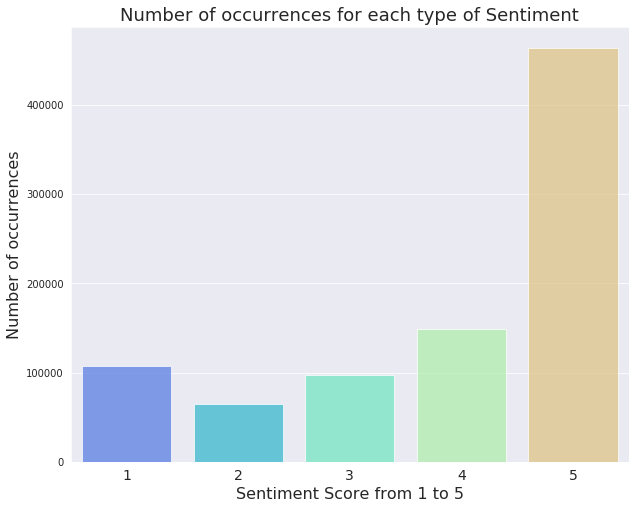

In [29]:
sentimentsList=['1','2','3','4','5']
sns.set_style('darkgrid')
sns.set_palette('rainbow')
plt.figure(figsize=(10,8))
sns.barplot(x='overall', y='count',data=dfPlotVaderSentiment, alpha=0.7)
plt.title('Number of occurrences for each type of Sentiment',fontsize=18)
plt.xticks(np.arange(5),sentimentsList)
plt.setp(plt.gca().get_xticklabels(), fontsize=14)
plt.xlabel('Sentiment Score from 1 to 5',fontsize=16)
plt.ylabel('Number of occurrences',fontsize=16)
plt.show()

In [57]:
sizes

[106916, 149103, 96949, 64669, 464263]

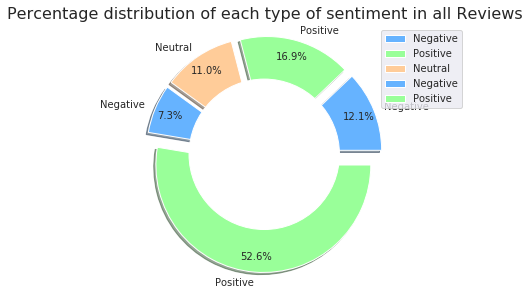

In [31]:
# labels = ['Positive' if sentiment>=4 else 'Negative' for sentiment in dfPlotVaderSentiment['overall'].tolist() ]
# labels =['5','4','3','2','1']
labels =[]
for sentiment in dfPlotVaderSentiment['overall'].tolist():
    if sentiment <=2:
        labels.append('Negative')
    elif sentiment ==3:
        labels.append('Neutral')
    else:
        labels.append('Positive')
        
sizes = dfPlotVaderSentiment['count'].tolist()
explode= (0.10,0.10,0.10,0.10,0.10)
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.pie(dfPlotVaderSentiment['count'],  labels=labels, colors=colors, shadow=True, autopct='%1.1f%%'
        ,explode=explode, pctdistance=0.85)

'''
draw circle
'''
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.title('Percentage distribution of each type of sentiment in all Reviews',fontsize=16)
plt.legend(loc='upper right', labels=labels)
plt.show()

In [32]:
dfSentimentScorepos.select('overall','filteredCleanedreviewText','sentimentScore','sentimentneu','sentimentneg','sentimentpos').show(5)

+-------+-------------------------+--------------+------------+------------+------------+
|overall|filteredCleanedreviewText|sentimentScore|sentimentneu|sentimentneg|sentimentpos|
+-------+-------------------------+--------------+------------+------------+------------+
|    5.0|     exactly need perf...|        0.5719|       0.448|         0.0|       0.552|
|    2.0|     agree review open...|        0.6124|         0.8|         0.0|         0.2|
|    4.0|     love go order ano...|        0.8126|       0.597|       0.085|       0.318|
|    2.0|     tiny opening two ...|           0.0|         1.0|         0.0|         0.0|
|    3.0|          okay three star|        0.2263|       0.513|         0.0|       0.487|
+-------+-------------------------+--------------+------------+------------+------------+
only showing top 5 rows



In [33]:
filteredCleanedreviewTextRddList = dfSentimentScorepos.select('filteredCleanedreviewText').collect()
filteredCleanedreviewTextList = [row.filteredCleanedreviewText for row in filteredCleanedreviewTextRddList]
wordList = []
for filteredCleanedreviewText in filteredCleanedreviewTextList:
     wordList.append(filteredCleanedreviewText.split(' '))
allreviewWords = [word for subList in wordList for word in subList]
'''
Remove empty strings
'''
allreviewWords = list(filter(None, allreviewWords))

In [34]:
allreviewWords=set(allreviewWords)
frequencyDistribution = nltk.FreqDist(allreviewWords)
sorted(frequencyDistribution,key=frequencyDistribution.__getitem__,reverse=False)[0:200]

['machiene',
 'amy',
 'milanas',
 'cumfertble',
 'tvmerch',
 'getr',
 'lunchlady',
 'ots',
 'easiliy',
 'ugghhh',
 'plasi',
 'themmnmmmmm',
 'encantaaaaaa',
 'symbolization',
 '1000000',
 'kaput',
 'purrfectly',
 'kendall',
 'brst',
 'desiners',
 'wowd',
 'procedure',
 'keyright',
 'nonslips',
 'outlast',
 'folly',
 'mnms',
 'orherwise',
 'panting',
 'exoercism',
 'swingset',
 'modesty',
 'daaged',
 'tripper',
 'conquest',
 'evidently',
 'telescop',
 'impregnate',
 'hha',
 'heeead',
 'uncoated',
 'stargate',
 '2795',
 'expeced',
 'straighted',
 'brillant',
 'panache',
 'headset',
 'sponge',
 'infotainment',
 'orthopod',
 'unaceptable',
 'receivedo',
 'adverage',
 'momobaby',
 'diper',
 'easliy',
 'prwtty',
 'lovs',
 'aquapac',
 'henly',
 'placinh',
 'longgggggg',
 'jibbet',
 'carboned',
 'ww2',
 'paillettr',
 'desechable',
 'fantastical',
 'shiggy',
 'gettig',
 'waah',
 '93lb',
 'invisalign',
 'bootman',
 '7b',
 'diminuitive',
 'brotherhood',
 'coochy',
 'correct',
 'receptive',
 'musl

In [35]:
def getWordCloud(wordList,color):
    stopWords = set(STOPWORDS)
    allWords = ' '.join([word for word in wordList])
    wordCloud = WordCloud(background_color=color,
                          stopwords=stopWords,
                          width=1600,
                          height=800,
                          random_state=21,
                          max_words=100,
                          max_font_size=200).generate(allWords)
    
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(wordCloud, interpolation='bilinear');

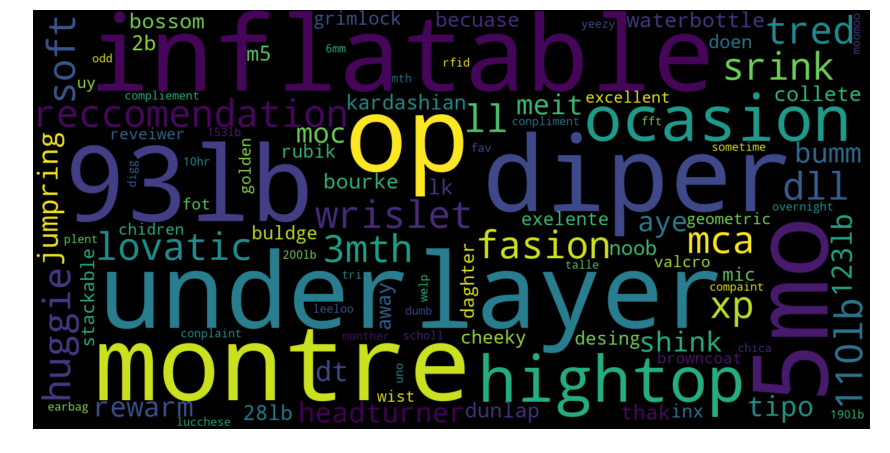

In [36]:
getWordCloud(allreviewWords,'black')

In [37]:
dfmodel_data = dfSentimentScorepos

In [38]:
dfmodel_data.show()

+-------+--------------------+-------------------------+--------------+------------+------------+------------+
|overall|                lems|filteredCleanedreviewText|sentimentScore|sentimentneg|sentimentneu|sentimentpos|
+-------+--------------------+-------------------------+--------------+------------+------------+------------+
|    5.0|[exactly, need, p...|     exactly need perf...|        0.5719|         0.0|       0.448|       0.552|
|    2.0|[agree, review, o...|     agree review open...|        0.6124|         0.0|         0.8|         0.2|
|    4.0|[love, go, order,...|     love go order ano...|        0.8126|       0.085|       0.597|       0.318|
|    2.0|[tiny, opening, t...|     tiny opening two ...|           0.0|         0.0|         1.0|         0.0|
|    3.0| [okay, three, star]|          okay three star|        0.2263|         0.0|       0.513|       0.487|
|    5.0|[exactly, want, f...|     exactly want five...|        0.0772|         0.0|       0.698|       0.302|
|